#load origin data
import os
import numpy as np

lines = np.loadtxt('./sample_submission.csv',delimiter=',', dtype=str)
data = lines[1:].astype(int)

lines = np.loadtxt('./train.csv', delimiter=',', dtype=str)
[nrow, ncol] = lines.shape
print nrow, ncol
#lines[0]
train_id = lines[1:, 0].astype(int)
train_target = lines[1:, ncol-1].astype(int)
train_data_ori = lines[1:, 1:ncol-1].astype(float)
feature_names = lines[0,:]

#read test data
lines = np.loadtxt('./test.csv', delimiter=',', dtype=str)
test_id = lines[1:, 0].astype(int)
test_data_ori = lines[1:, 1:ncol-1].astype(float)
print 'Done load train&test data'

#delete single-value features

from sklearn.feature_selection import VarianceThreshold

varThresProb = 1.
sel = VarianceThreshold(varThresProb*(1-varThresProb))
train_data = sel.fit_transform(train_data_ori)

#MODEL PARAM
param_selected_indices = sel.get_support(indices=True)

print 'Done delete redundant features'

In [20]:
#load data
import numpy as np
import pandas as pd

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [29]:
#load data and delete redundant data

remove = []

for col in df_train:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)
print (df_train.values).shape

remove = []
for i in range(df_train.shape[1]):
    for j in range(i+1, df_train.shape[1]):
        if np.array_equal(df_train[df_train.columns[i]].values,df_train[df_train.columns[j]].values):
            remove.append(df_train.columns[j])
df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

print (df_train.values).shape

train_data_id = df_train['ID'].values
test_data_id = df_test['ID'].values
#print train_data_id.shape

train_data_target = df_train['TARGET'].values
#print train_data_target.shape

train_data = df_train.drop(['ID', 'TARGET'],axis=1).values
test_data = df_test.drop(['ID'],axis=1).values
print train_data.shape
print test_data.shape

(76020, 308)
(76020, 308)
(76020, 306)
(75818, 306)


In [30]:
#training data type analyses

def type_analyses(nums):
    data_type = 1 #int
    for num in nums:
        if(round(float(num)) != float(num)): #float
            data_type = 2
    if (data_type == 1) & (nums.shape[0]==2):
        data_type = 0
    return data_type

unique_data = []
unique_data_size = []
unique_data_type = []
typeName = ['bool', 'int', 'float']

for i in range(train_data.shape[1]):
    values = np.unique(train_data[:,i])
    unique_data.append(values)
    unique_data_size.append(values.shape)
    feature_type = type_analyses(values)
    unique_data_type.append(feature_type)


param_bool_feature_indices = np.argwhere(np.array(unique_data_type)==0).reshape(unique_data_type.count(0))
param_int_feature_indices = np.argwhere(np.array(unique_data_type)==1).reshape(unique_data_type.count(1))
param_float_feature_indices = np.argwhere(np.array(unique_data_type)==2).reshape(unique_data_type.count(2))

print '%d bool, %d int and %d float' % (unique_data_type.count(0), 
                                        unique_data_type.count(1), 
                                        unique_data_type.count(2))

83 bool, 113 int and 110 float


In [31]:
#functions def
#for train&test dataset preprocessing

from sklearn.preprocessing import scale
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import robust_scale

#preprocess alg

def get_range_bool(train_data_bool):
    list_range_bool = []
    for i in range(train_data_bool.shape[1]):
        values = np.unique(train_data_bool[:,i])
        vzero = np.min(values)
        vone = np.max(values)
        list_range_bool.append([vzero,vone])
    return np.transpose(np.array(list_range_bool))

def get_range_int (train_data_int):
    #check int value range    
    list_range_int = []
    for i in range(train_data_int.shape[1]):
        list_range_int.append([np.min(train_data_int[:,i]),np.max(train_data_int[:,i])])
    return np.transpose(np.array(list_range_int))

def scale_float(float_features_ori):
    return maxabs_scale(float_features_ori, axis=0)

def scale_bool (bool_features_ori, bool_feature_range):
    bool_features = np.asarray(bool_features_ori)
    for i in range(bool_features.shape[0]):
        for j in range(bool_features.shape[1]):
            if bool_features[i,j]==bool_feature_range[0,j]:
                bool_features[i,j] = 0
            else:
                bool_features[i,j] = 1
    ##old version
    #bool_features = bool_features_ori - np.min(bool_features_ori, axis=0).reshape(1, bool_features_ori.shape[1])
    #bool_features = bool_features / np.max(bool_features, axis=0).reshape(1,bool_features.shape[1])
    return bool_features

def scale_int (int_features_ori, int_feature_range):
    int_features = np.array(int_features_ori)
    for i in range(int_features.shape[1]):
        pos_neg_feature = -2 #pos+neg
        if (int_feature_range[0,i] <0) & (int_feature_range[1, i] <=0):
            pos_neg_feature = -1
        if (int_feature_range[0,i] <0 ) & (int_feature_range[1, i] >0):
            pos_neg_feature = 0
        if (int_feature_range[0,i] >=0) & (int_feature_range[1, i] >0):
            pos_neg_feature = 1

        #scale
        for j in range(int_features.shape[0]):
            if int_features[j,i] < int_feature_range[0,i]:
                int_features[j,i] = int_feature_range[0,i];
            if int_features[j,i] > int_feature_range[1,i]:
                int_features[j,i] = int_feature_range[1,i];
            if pos_neg_feature == -1:
                int_features[j,i] = int_features[j,i]/-int_feature_range[0,i]
                if int_features[j,i] < -1:
                    int_features[j,i] = -1.0
            if pos_neg_feature == 0:
                if int_features[j,i] < 0:
                    int_features[j,i] = int_features[j,i]/-int_feature_range[0,i]
                    if int_features[j,i] < -1:
                        int_features[j,i] = -1.0
                else:
                    int_features[j,i] = int_features[j,i]/int_feature_range[1,i]
                    if int_features[j,i] > 1:
                        int_features[j,i] = 1.0
            if pos_neg_feature == 1:
                int_features[j,i] = int_features[j,i]/int_feature_range[1,i]
                if int_features[j,i] > 1:
                    int_features[j,i] = 1.0
    return int_features

#debug alg
def printarray(data):
    print data.shape
    print data
    #print np.unique(data)
    #print [np.sum(data==i) for i in np.unique(data)]
    #print np.unique(scale(test_data))
    #print np.unique(maxabs_scale(test_data))
    #print np.unique(robust_scale(test_data))
    #print np.sum(test_data==np.unique(test_data)[0])

In [130]:
#scale data based on type


do_type_part = True

if do_type_part:
    train_data_bool = train_data[:,param_bool_feature_indices]
    train_data_int = train_data[:, param_int_feature_indices]
    train_data_float = train_data[:, param_float_feature_indices]
    
    #test data preprocessing
    test_data_bool = test_data[:,param_bool_feature_indices]
    test_data_int = test_data[:, param_int_feature_indices]
    test_data_float = test_data[:, param_float_feature_indices]
    
    ##Generate MODEL PARAM
    param_bool_feature_range = get_range_bool(train_data_bool)
    #scale bool feature
    train_data_bool_scale = scale_bool(train_data_bool, param_bool_feature_range)
    test_data_bool_scale = scale_bool(test_data_bool, param_bool_feature_range)
    
    ##Generate MODEL PARAM
    #param_int_feature_range = get_range_int(train_data_int)
    ##scale int feature:
    #train_data_int_scale = scale_int(train_data_int, param_int_feature_range)
    #test_data_int_scale = scale_int(test_data_int, param_int_feature_range)
    
    #scale float feaure:
    #data_float_scale = scale_float(np.row_stack((train_data_float, test_data_float)))
    #train_data_float_scale = data_float_scale[:train_data_float.shape[0], :]
    #test_data_float_scale = data_float_scale[train_data_float.shape[0] : , :]
    
    #printarray(train_data_float_scale[:,0])
    #train_data_scale = np.column_stack((train_data_bool_scale, train_data_int_scale, train_data_float_scale))
    #test_data_scale = np.column_stack((test_data_bool_scale, test_data_int_scale, test_data_float_scale))
    
    train_data_scale = np.column_stack((train_data_bool, train_data_int, train_data_float))
    test_data_scale = np.column_stack((test_data_bool, test_data_int, test_data_float))
    
    print train_data_scale.shape
    print test_data_scale.shape
    
print "Done type analysis and scale!"

(76020, 306)
(75818, 306)
Done type analysis and scale!


In [131]:
cols = df_train.columns
#print cols[1:cols.shape[0]-1]
#print df_train.loc[:,cols[1:cols.shape[0]-1]]
df_train.loc[:,cols[1:cols.shape[0]-1]] = train_data_scale
df_test.loc[:,cols[1:cols.shape[0]-1]] = test_data_scale

In [132]:
df_train.to_csv('./train_data_scale_nofloat_noint.csv')
df_test.to_csv('./test_data_scale_nofloat_noint.csv')
print df_train.shape
print df_test.shape

(76020, 308)
(75818, 307)


#save scaled train/test data

#save param_* 
import csv
with open('data_processing_param.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(param_selected_indices)
    f_csv.writerow(param_bool_feature_indices)
    f_csv.writerow(param_int_feature_indices)
    f_csv.writerow(param_float_feature_indices)
    f_csv.writerows(param_bool_feature_range)
    f_csv.writerows(param_int_feature_range)
    
    
#save header + scaled data
headers = np.ndarray((param_selected_indices.shape[0]+2),dtype=feature_names.dtype)
headers[1:param_selected_indices.shape[0]+1] = feature_names[param_selected_indices+1]
headers[0] = feature_names[0]
headers[param_selected_indices.shape[0]+1] = feature_names[feature_names.shape[0]-1]
data_scale_id_target = np.column_stack((train_id, train_data_scale, train_target))
print headers.shape
print data_scale_id_target.shape
with open('train_data_scale.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerows(data_scale_id_target)
print 'Done saving scaled training data'

#test data read/select/scale

#load params from taining data analysis
import csv
with open('./data_processing_param.csv') as f:
    f_csv = csv.reader(f)
    params = []
    for row in f_csv:
        params.append(np.array(row).astype(float))
param_selected_indices = params[0].astype(int)
param_bool_feature_indices = params[1].astype(int)
param_int_feature_indices = params[2].astype(int)
param_float_feature_indices = params[3].astype(int)
param_bool_feature_range = np.asarray(np.row_stack((params[4],params[5])))
param_int_feature_range = np.asarray(np.row_stack((params[6],params[7])))

#select features
test_data = test_data_ori[:,param_selected_indices.astype(int)]
test_data_bool = test_data[:,param_bool_feature_indices]
test_data_int = test_data[:,param_int_feature_indices]
test_data_float = test_data[:,param_float_feature_indices]

#scale bool features
test_data_bool_scale = scale_bool(test_data_bool, param_bool_feature_range)
test_data_int_scale = scale_int(test_data_int, param_int_feature_range)
test_data_float_scale = scale_float(test_data_float)

test_data_scale = np.column_stack((test_data_bool_scale, test_data_int_scale, test_data_float_scale))

#printarray(test_data_scale)
print 'Done scale test data'

In [1]:
#training start load preprocessed data
import pandas as pd
import numpy as np

df_train_scale = pd.read_csv('./train_data_scale_nofloat_noint.csv')
df_test_scale = pd.read_csv('./test_data_scale_nofloat_noint.csv')

df_train_scale.replace(-99999, 2)
df_test_scale.replace(-99999, 2)

train_data_target = df_train_scale['TARGET'].values
test_data_id = df_test_scale['ID'].values

train_data_scale = df_train_scale.drop(['ID','TARGET'], axis=1).values
test_data_scale = df_test_scale.drop(['ID'], axis=1).values


In [2]:
#Boosting 
#ref: https://www.kaggle.com/cast42/santander-customer-satisfaction/xgboost-with-early-stopping/code

from sklearn import cross_validation as cv

print train_data_target.shape

# train_data_scale_n = np.row_stack((train_data_scale, train_data_scale[(train_data_target==1),:]))
# train_data_target_n = np.hstack((train_data_target, train_data_target[train_data_target==1]))


x_train, x_test, y_train, y_test = \
cv.train_test_split(train_data_scale, train_data_target, test_size=0.3, stratify=train_data_target)


(76020,)


In [3]:
print np.sum(y_train==0)
print np.sum(y_train==1)
print np.sum(y_test==0)
print np.sum(y_test==1)

51108
2106
21904
902


In [5]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# ##[166]	validation_0-auc:0.883586	validation_1-auc:0.833347
# ##('Overall AUC:', 0.86816240395414446)
# ##test score: 0.830436
# clf = xgb.XGBClassifier(missing=9999999999,
#                 max_depth = 8,
#                 n_estimators=1000,
#                 learning_rate=0.05, 
#                 nthread=4,
#                 subsample=0.8,
#                 colsample_bytree=0.5,
#                 min_child_weight = 8,
#                 seed=4242)

# #('Overall AUC:', 0.87137364469597534)
# #Stopping. Best iteration:
# #[150]	validation_0-auc:0.887866	validation_1-auc:0.833577
# clf = xgb.XGBClassifier(missing=9999999999,
#                 max_depth = 9,
#                 n_estimators=1000,
#                 learning_rate=0.05, 
#                 nthread=4,
#                 subsample=0.8,
#                 colsample_bytree=0.5,
#                 min_child_weight = 8,
#                 seed=4242)

# ##('Overall AUC:', 0.8721795864254609)
# ##Stopping. Best iteration:
# ##[131]	validation_0-auc:0.889038	validation_1-auc:0.833293
# clf = xgb.XGBClassifier(missing=9999999999,
#                 max_depth = 10,
#                 n_estimators=1000,
#                 learning_rate=0.05, 
#                 nthread=4,
#                 subsample=0.8,
#                 colsample_bytree=0.5,
#                 min_child_weight = 8,
#                 seed=4242)


##('Overall AUC:', 0.88376225142894027)
##[203]	validation_0-auc:0.912779	validation_1-auc:0.832430
##Stopping. Best iteration:
##[153]	validation_0-auc:0.905169	validation_1-auc:0.833714
###double class 1 sample
##('Overall AUC:', 0.9541665781805323)
##[999]	validation_0-auc:0.972681	validation_1-auc:0.907279
# clf = xgb.XGBClassifier(missing=9999999999,
#                 max_depth = 10,
#                 n_estimators=1000,
#                 learning_rate=0.05, 
#                 nthread=4,
#                 subsample=0.8,
#                 colsample_bytree=0.5,
#                 min_child_weight = 5,
#                 seed=4242)

##('Overall AUC:', 0.89180781297900902)
##Stopping. Best iteration:
##[166]	validation_0-auc:0.916351	validation_1-auc:0.835339

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 12,
                n_estimators=1000,
                learning_rate=0.05, 
                nthread=4,
                subsample=0.8,
                colsample_bytree=0.5,
                min_child_weight = 8,
                seed=1030)

clf.fit(x_train, y_train, early_stopping_rounds=70, eval_metric="auc",
        eval_set=[(x_train, y_train), (x_test, y_test)])
        
print('Overall AUC:', roc_auc_score(train_data_target, clf.predict_proba(train_data_scale, ntree_limit=clf.best_iteration)[:,1]))

Will train until validation_1 error hasn't decreased in 70 rounds.
[0]	validation_0-auc:0.728099	validation_1-auc:0.704386
[1]	validation_0-auc:0.822773	validation_1-auc:0.797885
[2]	validation_0-auc:0.833801	validation_1-auc:0.810357
[3]	validation_0-auc:0.831156	validation_1-auc:0.804740
[4]	validation_0-auc:0.837484	validation_1-auc:0.810879
[5]	validation_0-auc:0.843125	validation_1-auc:0.817892
[6]	validation_0-auc:0.839880	validation_1-auc:0.811201
[7]	validation_0-auc:0.842330	validation_1-auc:0.809386
[8]	validation_0-auc:0.844859	validation_1-auc:0.813393
[9]	validation_0-auc:0.847608	validation_1-auc:0.816915
[10]	validation_0-auc:0.847871	validation_1-auc:0.815148
[11]	validation_0-auc:0.847142	validation_1-auc:0.813676
[12]	validation_0-auc:0.848555	validation_1-auc:0.812956
[13]	validation_0-auc:0.846749	validation_1-auc:0.810151
[14]	validation_0-auc:0.850080	validation_1-auc:0.812176
[15]	validation_0-auc:0.850044	validation_1-auc:0.810840
[16]	validation_0-auc:0.852241	

('Overall AUC:', 0.89558959804844096)


Stopping. Best iteration:
[136]	validation_0-auc:0.922060	validation_1-auc:0.831893



In [6]:
#test
y_pred = clf.predict_proba(test_data_scale, ntree_limit=clf.best_iteration)
#print y_pred
submission = pd.DataFrame({"ID":test_data_id, "TARGET":y_pred[:,1]})
submission.to_csv("submission_nofloat_noint.csv", index=False)

y_pred_class = clf.predict(test_data_scale, ntree_limit=clf.best_iteration)
print np.unique(y_pred_class)
print np.sum(y_pred_class == 0)
print np.sum(y_pred_class == 1)
#submission_class = submission = pd.DataFrame({"ID":test_data_id, "TARGET":y_pred_class})
#submission_class.to_csv('submission_class.csv', index=False)

[0 1]
75799
19


In [113]:
#Find the wrong answers
train_pred_target = clf.predict

(75818, 307)


Done PCA analysis with components = 2
<type 'list'>
[(0, 'o', (0.0, 0.63, 0.69), 0), (1, 'D', 'black', 0)]
ll: 0o(0.0, 0.63, 0.69)Satisfied customer
ll: 1DblackUnsatisfied customer


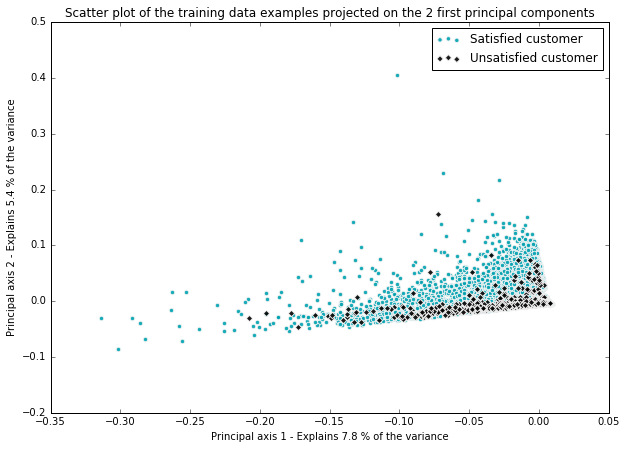

In [67]:
#pca analyses
#ref:https://www.kaggle.com/tuomastik/santander-customer-satisfaction/pca-visualization/code

#data normalization

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

do_l2_norm = True

#train_data normalization
if do_l2_norm:
    train_data_norm = normalize(train_data_scale, axis=0)
else:
    train_data_norm = train_data_scale
#print np.sum(train_data_norm[:,:2], axis=0)
pca = PCA(n_components=2)
train_data_pca = pca.fit_transform(train_data_norm)

print "Done PCA analysis with components = 2"


#plot

%matplotlib inline
from matplotlib import pyplot as plt

classes = np.sort(np.unique(train_target))
labels = ["Satisfied customer", "Unsatisfied customer"]
# Visualize
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = [(0.0, 0.63, 0.69), 'black']
markers = ["o", "D"]
print type(zip(classes, markers, colors, train_target))
print zip(classes, markers, colors, train_target)
for class_ix, marker, color, label in zip(
        classes, markers, colors, labels):
    print 'll: '+ str(class_ix) + str(marker) + str(color) + str(label)
    ax.scatter(train_data_pca[train_target==class_ix, 0],
               train_data_pca[train_target==class_ix, 1],
               c=color, marker=marker, edgecolor='whitesmoke', 
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')

plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()
#plt.savefig("./pca.pdf", format='pdf')
#plt.savefig("./pca.png", format='png')


#for dev, use 1 batch
batch_size = 100
train_data_b = train_data[:100]

print nsample
print nfeature

for class_ix, marker, color, label in zip(
        classes, markers, colors, train_target):
    ax.scatter(train_data_pca[np.where(train_target == class_ix), 0],
               train_data_pca[np.where(train_target == class_ix), 1],
               marker=marker, color=color, edgecolor='whitesmoke',
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()
plt.savefig("pca.pdf", format='pdf')
plt.savefig("pca.png", format='png')